# Comparison of Landscape Classification Accuracy with Varying Depth of CNN and Training Time

Daniel Shklyarman: 100851439 

## Introduction

[The Dataset](https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images)

When training a CNN, many hyper-parameters are decided arbitrarily as their effect on the final accuracy is difficult to predict. Here I compare the effects of varying number of convolutional layers and training time on the accuracy of the final model, using the landscape dataset as an example.

## Imports

In [9]:
# Import the .py file where the models are
import models
from importlib import reload

# Folder Navigation
import os
import shutil

# Data Loading
import random
from pandas.core.common import flatten
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Torch
import torch
import torchvision

# Image Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Training and Logging
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything
import pandas as pd
import torchinfo

# Displaying Metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data Loading

### Create Training, Validation, and Test Sets

In [21]:
# Get Data Paths
# Assumes dataset folder is in same folder as this notebook
train_data_path = os.getcwd() + r'\landscapes\Landscape Classification\Training Data' 
valid_data_path = os.getcwd() + r'\landscapes\Landscape Classification\Validation Data' 
test_data_path = os.getcwd() + r'\landscapes\Landscape Classification\Testing Data' 

# Store image paths in list
train_image_paths = []
valid_image_paths = [] 
test_image_paths = []

# Store class values
train_classes = [] 
valid_classes = []


# Get all the paths from train_data_path and append image paths and class to to respective lists
for data_path in os.listdir(train_data_path):
    train_classes.append(data_path.split('\\')[-1]) 
    images = os.listdir(os.path.join(train_data_path, data_path))
    paths = [os.path.join(os.getcwd(), train_data_path, data_path, image) for image in images]
    train_image_paths.append(paths)
    
# Get all the paths from valid_data_path and append image paths and class to to respective lists
for data_path in os.listdir(valid_data_path):
    valid_classes.append(data_path.split('\\')[-1])  
    images = os.listdir(os.path.join(valid_data_path, data_path))
    paths = [os.path.join(os.getcwd(), valid_data_path, data_path, image) for image in images]
    valid_image_paths.append(paths)

# Create the test_image_paths
for data_path in os.listdir(test_data_path): 
    images = os.listdir(os.path.join(test_data_path, data_path))
    paths = [os.path.join(os.getcwd(), test_data_path, data_path, image) for image in images]
    test_image_paths.append(paths)


# Convert to list instead of a list with lists of paths as its elements
# [[], [], ..., []] -> [...]
train_image_paths = list(flatten(train_image_paths))
valid_image_paths = list(flatten(valid_image_paths))
test_image_paths = list(flatten(test_image_paths))

# Shuffle Data
random.shuffle(train_image_paths)
random.shuffle(valid_image_paths)


# Display a few examples
print('train_image_path example: ', train_image_paths[0])
print('class example: ', train_classes[0])

print('valid_image_path example: ', valid_image_paths[0])
print('class example: ', valid_classes[0])

# Print train, valid, and test set sizes
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  c:\Users\shkly\Downloads\Ontario Tech\2023 Fall\CSCI 4050U\Final\landscapes\Landscape Classification\Training Data\Desert\Desert-Train (1004).jpeg
class example:  Coast
valid_image_path example:  c:\Users\shkly\Downloads\Ontario Tech\2023 Fall\CSCI 4050U\Final\landscapes\Landscape Classification\Validation Data\Mountain\Mountain-Valid (172).jpeg
class example:  Coast
Train size: 10000
Valid size: 1500
Test size: 500


### Image Augmentation / Defining Transforms

In [22]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),                                                            # Rescales Image to keep aspect ratio
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),            # Randomly applies shift, scaling, and rotation to the image
        A.RandomCrop(height=256, width=256),                                                        # Crops a random part of the image
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),                    # Randomly shifts values of each channel of RGB image
        A.RandomBrightnessContrast(p=0.5),                                                          # Randomly changes brightness and contrast
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),                         # Multiplies the image array by given multiplier
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),                         # Normalizes pixel values
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5), # Randomly changes hue and saturation
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), # Randomly changes brightness and contrast
        ToTensorV2(),

        # More details can be found at albumentations.ai/docs/getting_started/transforms_and_targets
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.augmentations.geometric.resize.Resize (256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

### Class to Index and Index to Class Dicts

In [23]:
idx_to_class = {i:j for i, j in enumerate(train_classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(idx_to_class)
print(class_to_idx)

{0: 'Coast', 1: 'Desert', 2: 'Forest', 3: 'Glacier', 4: 'Mountain'}
{'Coast': 0, 'Desert': 1, 'Forest': 2, 'Glacier': 3, 'Mountain': 4}


### Create Datasets

In [24]:
# Define Dataset class
class LandscapeDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_filepath = self.image_paths[index]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        return image, label

# Create Datasets
train_dataset = LandscapeDataset(train_image_paths,train_transforms)
valid_dataset = LandscapeDataset(valid_image_paths,test_transforms) 
test_dataset = LandscapeDataset(test_image_paths,test_transforms)

# Examples
print('50th train image shape: ',train_dataset[49][0].shape)
print('50th train image label: ',train_dataset[49][1])

50th train image shape:  torch.Size([3, 256, 256])
50th train image label:  3


### Create Dataloaders

In [25]:
train_loader = DataLoader(
    train_dataset, batch_size=512, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=512, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=512, shuffle=False
)

## Training

### Train Function

In [7]:
def train(model, epochs):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}{epochs}', ignore_errors=True)
    seed_everything(0, workers=True)
    logger = CSVLogger('./lightning_logs', name=f'{name}{epochs}')
    trainer = Trainer(max_epochs=epochs, logger=logger, deterministic=True)
    trainer.fit(model,
                train_dataloaders=train_loader,
                val_dataloaders=valid_loader)

### Function to Load Training Metrics

In [36]:
def show_metrics(name):
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('epoch', inplace=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    df[['train_step_acc']].dropna().plot(color='b', label = "Training Accuracy", ax=ax[0])
    df[['val_step_acc']].dropna().plot(color='r', label = "Validation Accuracy", ax=ax[0])
    ax[0].set_title("Accuracy")
    ax[0].set_ylabel("Accuracy (percent/100)")
    ax[0].legend()
    plt.figure()


    loss = df[['train_step_loss']].dropna().plot
    val_loss = df['val_step_loss']

    df[['train_step_loss']].dropna().plot(color='b', label = "Training Loss", ax=ax[1])
    df[['val_step_loss']].dropna().plot(color='r', label = "Validation Loss", ax=ax[1])
    ax[1].set_title("Loss")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    plt.figure()

    plt.tight_layout()
    plt.show()

    return df[['val_step_acc']].dropna().round(2)

### Function to Get Model Summary

In [9]:
def describe(model, **kwargs):
    return torchinfo.summary(model,
                             input_size=(512, 3, 256, 256),
                             col_names=['input_size', 'output_size', 'kernel_size', 'num_params'],
                             row_settings=['ascii_only'])

### Train 2 Layer CNN

##### Model Summary

In [154]:
reload(models)
model = models.DeepConvNet(5)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
DeepConvNet                              [512, 3, 256, 256]        [512, 5]                  --                        --
+ Sequential                             [512, 3, 256, 256]        [512, 5]                  --                        --
|    + Conv2d                            [512, 3, 256, 256]        [512, 16, 256, 256]       [3, 3]                    448
|    + MaxPool2d                         [512, 16, 256, 256]       [512, 16, 128, 128]       2                         --
|    + ReLU                              [512, 16, 128, 128]       [512, 16, 128, 128]       --                        --
|    + Conv2d                            [512, 16, 128, 128]       [512, 32, 128, 128]       [3, 3]                    4,640
|    + MaxPool2d                         [512, 32, 128, 128]       [512, 32, 64, 64]         2                         --
|    + ReLU    

#### Train 5 Epoch

In [155]:
reload(models)
model = models.DeepConvNet(5)
train(model, 5)

Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeepConvNet5

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 660 K 
------------------------------------------------
660 K     Trainable params
0         Non-trainable params
660 K     Total params
2.642     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 4: 100%|██████████| 20/20 [04:09<00:00,  0.08it/s, v_num=0, train_step_acc=0.529, val_step_acc=0.533]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 20/20 [04:09<00:00,  0.08it/s, v_num=0, train_step_acc=0.529, val_step_acc=0.533]


##### Training Logs

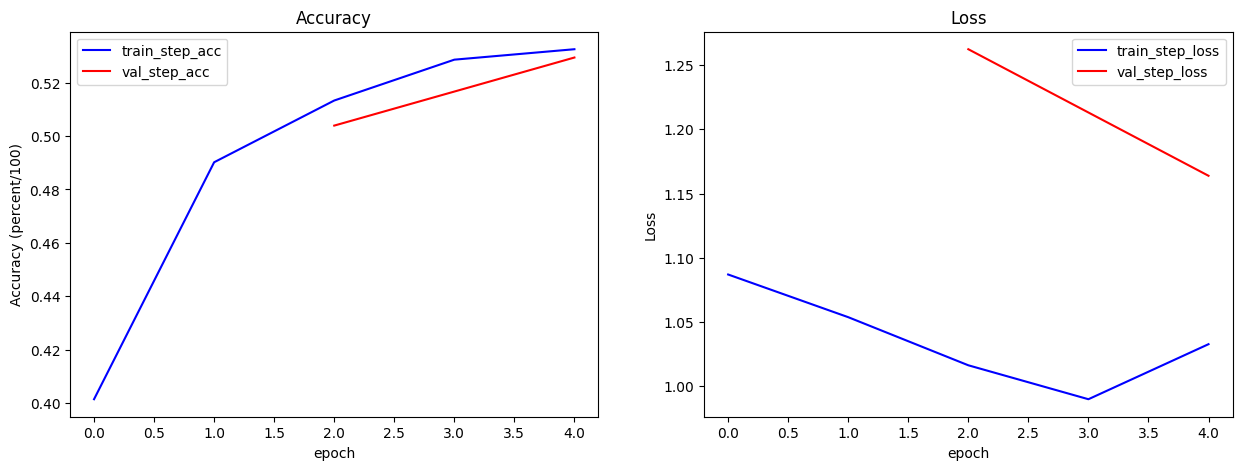

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.50
4,0.53


In [37]:
show_metrics('DeepConvNet5')

#### Train 10 Epoch

In [157]:
reload(models)
model = models.DeepConvNet(5)
train(model, 10)

Seed set to 0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeepConvNet10

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 660 K 
------------------------------------------------
660 K     Trainable params
0         Non-trainable params
660 K     Total params
2.642     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 20/20 [04:52<00:00,  0.07it/s, v_num=0, train_step_acc=0.551, val_step_acc=0.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [04:52<00:00,  0.07it/s, v_num=0, train_step_acc=0.551, val_step_acc=0.560]


##### Training Logs

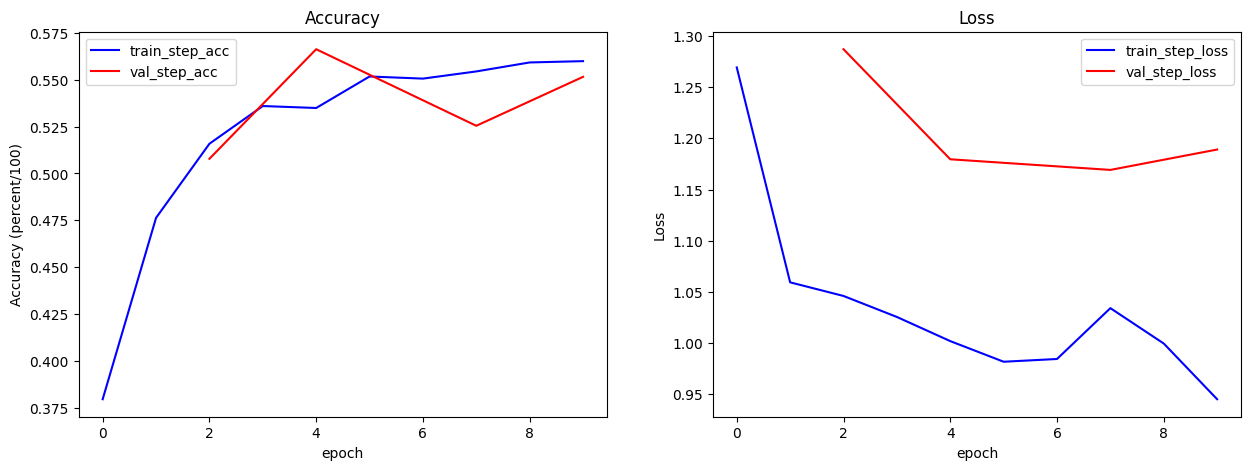

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.51
4,0.57
7,0.53
9,0.55


In [38]:
show_metrics('DeepConvNet10')

#### Train 15 Epoch

In [159]:
reload(models)
model = models.DeepConvNet(5)
train(model, 15)

Seed set to 0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeepConvNet15

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 660 K 
------------------------------------------------
660 K     Trainable params
0         Non-trainable params
660 K     Total params
2.642     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 20/20 [05:22<00:00,  0.06it/s, v_num=0, train_step_acc=0.529, val_step_acc=0.571]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 20/20 [05:22<00:00,  0.06it/s, v_num=0, train_step_acc=0.529, val_step_acc=0.571]


##### Training Logs

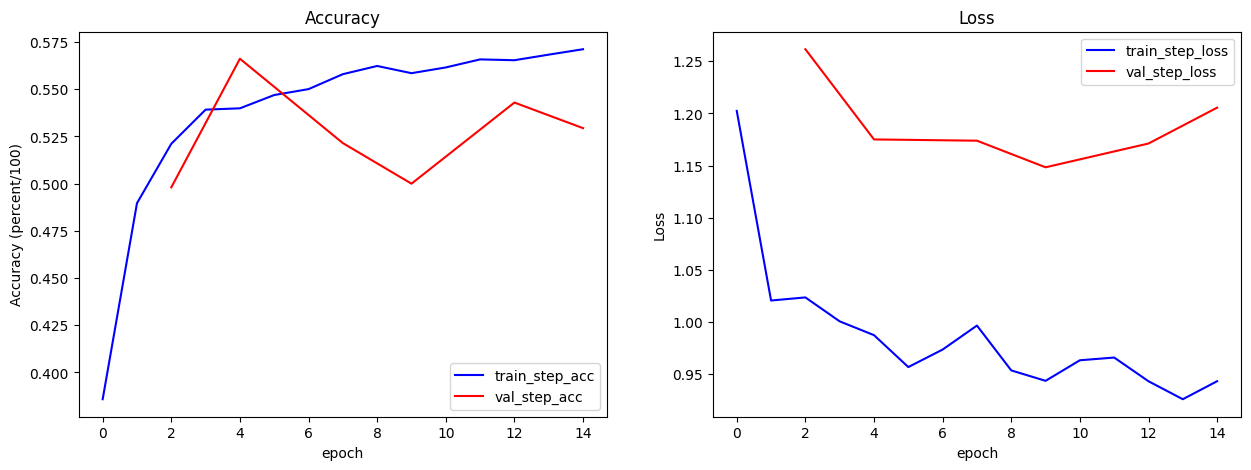

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.50
4,0.57
7,0.52
9,0.50
12,0.54
14,0.53


In [39]:
show_metrics('DeepConvNet15')

### Train 3 Layer CNN

##### Model Summary

In [161]:
reload(models)
model = models.DeeperConvNet(5)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
DeeperConvNet                            [512, 3, 256, 256]        [512, 5]                  --                        --
+ Sequential                             [512, 3, 256, 256]        [512, 5]                  --                        --
|    + Conv2d                            [512, 3, 256, 256]        [512, 16, 256, 256]       [3, 3]                    448
|    + MaxPool2d                         [512, 16, 256, 256]       [512, 16, 128, 128]       2                         --
|    + ReLU                              [512, 16, 128, 128]       [512, 16, 128, 128]       --                        --
|    + Conv2d                            [512, 16, 128, 128]       [512, 32, 128, 128]       [3, 3]                    4,640
|    + MaxPool2d                         [512, 32, 128, 128]       [512, 32, 64, 64]         2                         --
|    + ReLU    

#### Train 5 Epoch

In [162]:
reload(models)
model = models.DeeperConvNet(5)
train(model, 5)

Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeeperConvNet5

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 351 K 
------------------------------------------------
351 K     Trainable params
0         Non-trainable params
351 K     Total params
1.405     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 20/20 [06:01<00:00,  0.06it/s, v_num=0, train_step_acc=0.574, val_step_acc=0.550]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 20/20 [06:01<00:00,  0.06it/s, v_num=0, train_step_acc=0.574, val_step_acc=0.550]


##### Training Logs

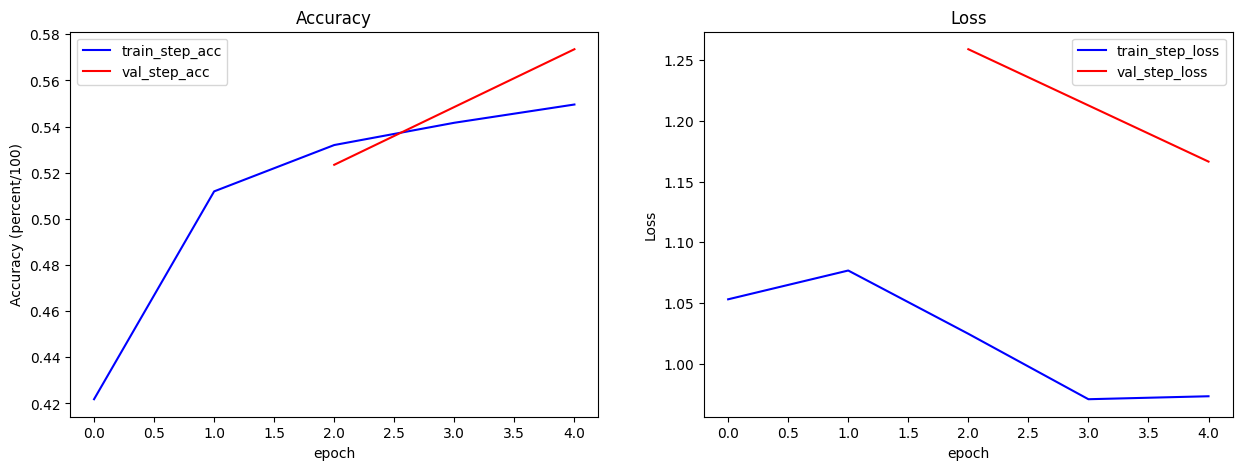

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.52
4,0.57


In [40]:
show_metrics('DeeperConvNet5')

#### Train 10 Epoch

In [164]:
reload(models)
model = models.DeeperConvNet(5)
train(model, 10)

Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeeperConvNet10

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 351 K 
------------------------------------------------
351 K     Trainable params
0         Non-trainable params
351 K     Total params
1.405     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 20/20 [05:54<00:00,  0.06it/s, v_num=0, train_step_acc=0.529, val_step_acc=0.566]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [05:54<00:00,  0.06it/s, v_num=0, train_step_acc=0.529, val_step_acc=0.566]


##### Training Logs

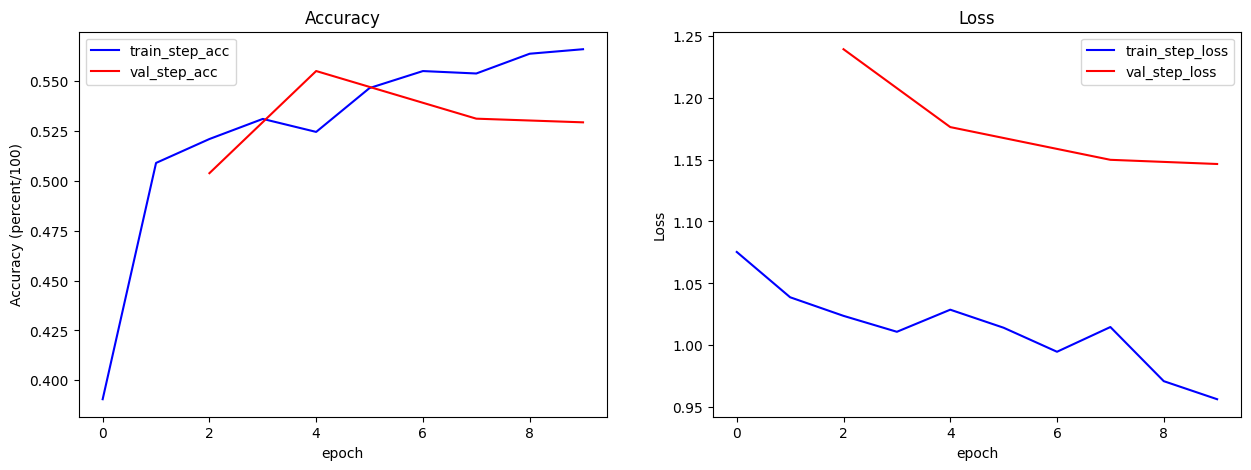

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.50
4,0.56
7,0.53
9,0.53


In [41]:
show_metrics('DeeperConvNet10')

#### Train 15 Epoch

In [10]:
reload(models)
model = models.DeeperConvNet(5)
train(model, 15)

Seed set to 0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeeperConvNet15

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 351 K 
------------------------------------------------
351 K     Trainable params
0         Non-trainable params
351 K     Total params
1.405     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 20/20 [05:34<00:00,  0.06it/s, v_num=0, train_step_acc=0.511, val_step_acc=0.577]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 20/20 [05:34<00:00,  0.06it/s, v_num=0, train_step_acc=0.511, val_step_acc=0.577]


##### Training Logs

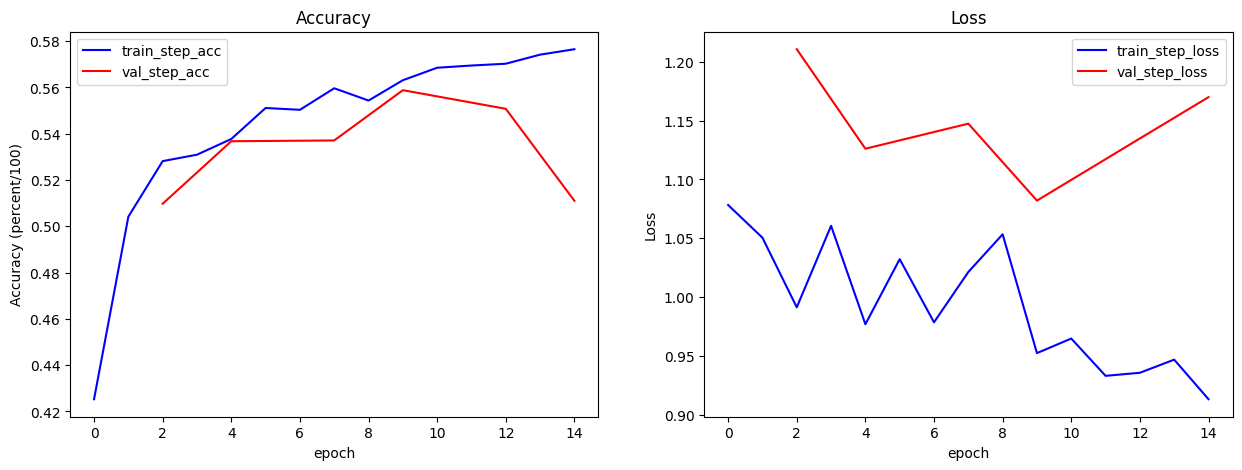

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.51
4,0.54
7,0.54
9,0.56
12,0.55
14,0.51


In [42]:
show_metrics('DeeperConvNet15')

### Train 4 Layer CNN

##### Model Summary

In [12]:
reload(models)
model = models.DeepestConvNet(5)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
DeepestConvNet                           [512, 3, 256, 256]        [512, 5]                  --                        --
+ Sequential                             [512, 3, 256, 256]        [512, 5]                  --                        --
|    + Conv2d                            [512, 3, 256, 256]        [512, 16, 256, 256]       [3, 3]                    448
|    + MaxPool2d                         [512, 16, 256, 256]       [512, 16, 128, 128]       2                         --
|    + ReLU                              [512, 16, 128, 128]       [512, 16, 128, 128]       --                        --
|    + Conv2d                            [512, 16, 128, 128]       [512, 32, 128, 128]       [3, 3]                    4,640
|    + MaxPool2d                         [512, 32, 128, 128]       [512, 32, 64, 64]         2                         --
|    + ReLU    

#### Train 5 Epoch

In [13]:
reload(models)
model = models.DeepestConvNet(5)
train(model, 5)

Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeepestConvNet5

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 261 K 
------------------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 20/20 [06:24<00:00,  0.05it/s, v_num=0, train_step_acc=0.555, val_step_acc=0.546]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 20/20 [06:24<00:00,  0.05it/s, v_num=0, train_step_acc=0.555, val_step_acc=0.546]


##### Training Logs

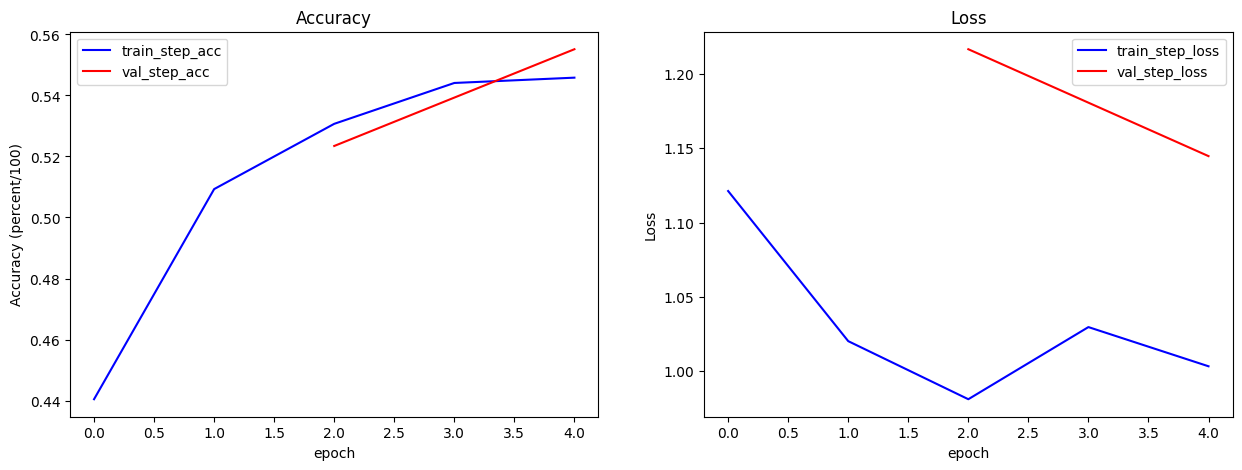

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.52
4,0.56


In [43]:
show_metrics('DeepestConvNet5')

#### Train 10 Epoch

In [10]:
reload(models)
model = models.DeepestConvNet(5)
train(model, 10)

Seed set to 0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeepestConvNet10

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 261 K 
------------------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 20/20 [05:27<00:00,  0.06it/s, v_num=0, train_step_acc=0.544, val_step_acc=0.564]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [05:27<00:00,  0.06it/s, v_num=0, train_step_acc=0.544, val_step_acc=0.564]


##### Training Logs

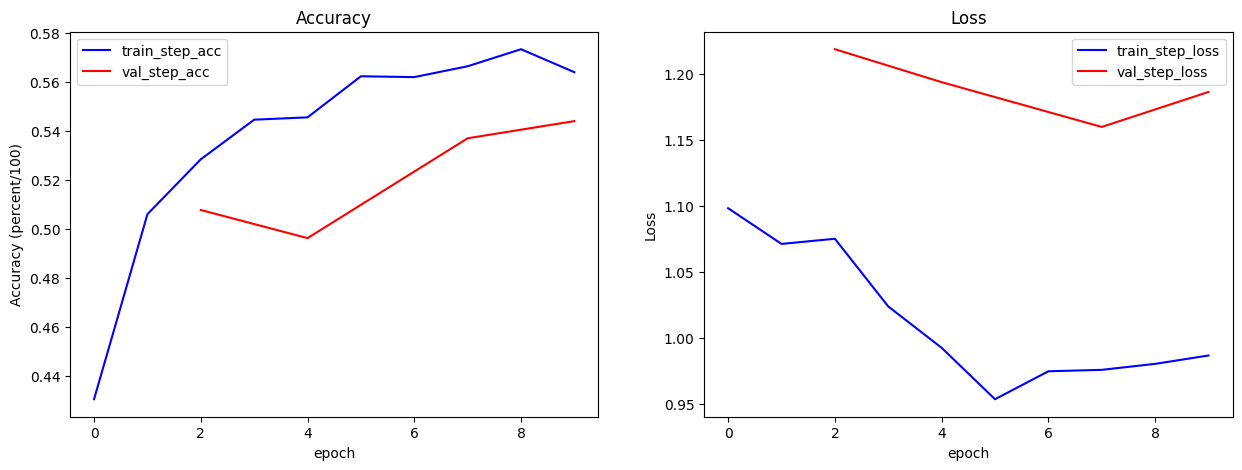

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.51
4,0.50
7,0.54
9,0.54


In [44]:
show_metrics('DeepestConvNet10')

#### Train 15 Epoch

In [12]:
reload(models)
model = models.DeepestConvNet(5)
train(model, 15)

Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\DeepestConvNet15

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 261 K 
------------------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 20/20 [05:26<00:00,  0.06it/s, v_num=0, train_step_acc=0.537, val_step_acc=0.593]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 20/20 [05:26<00:00,  0.06it/s, v_num=0, train_step_acc=0.537, val_step_acc=0.593]


##### Training Logs

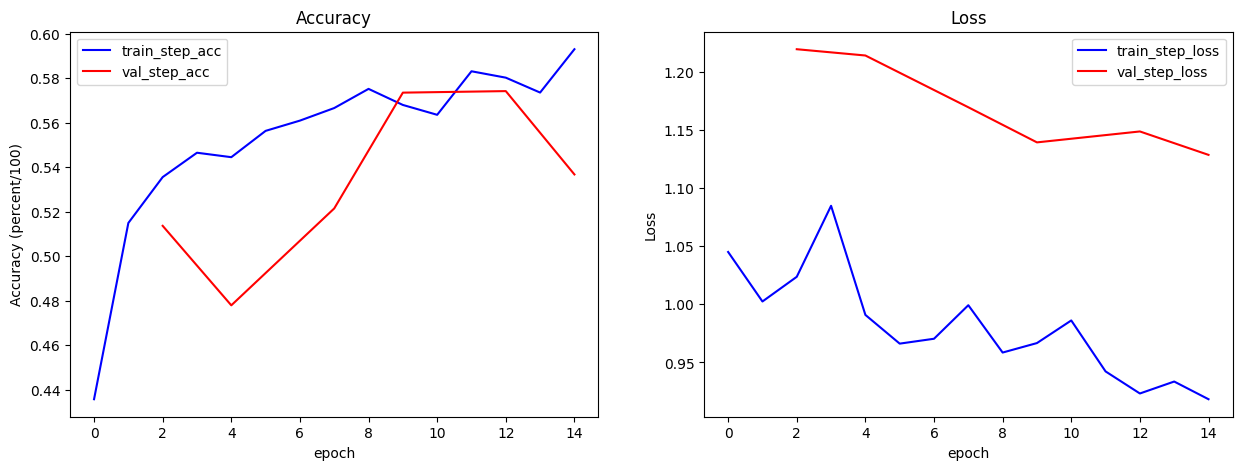

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

,val_step_acc
epoch,
2,0.51
4,0.48
7,0.52
9,0.57
12,0.57
14,0.54


In [45]:
show_metrics('DeepestConvNet15')

## Testing the Models

### Load Models

In [17]:
model_dict = {}

# Assumes Logs are in same folder as notebook
log_loc = os.getcwd() + r'\lightning_logs'
to_ckpt = r'version_0\checkpoints'

for path in os.listdir(log_loc):
    # Get checkpoint to load model
    
    ckpt_dir = os.path.join(log_loc, path, to_ckpt)
    ckpt = os.path.join(ckpt_dir, os.listdir(ckpt_dir)[0])

    # If/else because class names are taken from 'path' and the 
    # folder names include class_name + epochs , so if epochs = 5
    # then you need to take of the last character to get class name
    # but if epochs = 10 or 15 , then you need to take off the last 2

    if f'{path}'[-2] == '1':
        model_dict[f'{path}'] = eval(f'models.{path}'[:-2]).load_from_checkpoint(ckpt, num_classes=5)
    
    else: 
        model_dict[f'{path}'] = eval(f'models.{path}'[:-1]).load_from_checkpoint(ckpt, num_classes=5)

model_dict

{'DeepConvNet10': DeepConvNet(
   (accuracy): MulticlassAccuracy()
   (model): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): ReLU()
     (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): ReLU()
     (6): Flatten(start_dim=1, end_dim=-1)
     (7): Linear(in_features=131072, out_features=5, bias=True)
   )
 ),
 'DeepConvNet15': DeepConvNet(
   (accuracy): MulticlassAccuracy()
   (model): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): ReLU()
     (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): ReLU()


### Test Models

In [164]:
trainer = Trainer()

for key in model_dict:
    print(f'{key}: ', trainer.test(model=model_dict[key], dataloaders=test_loader, verbose=False), '\n')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s]
DeepConvNet10:  [{'test_step_acc': 0.6880000233650208, 'test_step_loss': 0.8589399456977844}] 

Testing DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s]
DeepConvNet15:  [{'test_step_acc': 0.6919999718666077, 'test_step_loss': 0.8471472859382629}] 

Testing DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s]
DeepConvNet5:  [{'test_step_acc': 0.6740000247955322, 'test_step_loss': 0.9079948663711548}] 

Testing DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s]
DeeperConvNet10:  [{'test_step_acc': 0.6899999976158142, 'test_step_loss': 0.8513643145561218}] 

Testing DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s]
DeeperConvNet15:  [{'test_step_acc': 0.7139999866485596, 'test_step_loss': 0.8126487135887146}] 

Testing DataLoader 0: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s]
DeeperConvNet5:  [{'test_step_acc': 0.699999988079071, 'test_step_loss': 0.8762142658233643}] 

Testing DataL

### Using the Models

In [26]:
def predict(model_name, image_path):
    # Get model
    model = model_dict[model_name]
    
    # Load the Image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = test_transforms(image=image)['image']

    # Transform from (3,256,256) -> (1,3,256,256)
    # Very important, will not work otherwise
    # The '1' acts as the batch size so that nn.Flatten()
    # works properly
    image = image.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        out = model(image)

        pred = idx_to_class[torch.IntTensor.item(torch.argmax(out[0]))]

        return pred

# Examples
# Assumes dataset is in same folder as notebook
print('Actual: Forest \nPredicted: ', predict('DeepConvNet5', 
             os.getcwd() + r'\landscapes\Landscape Classification\Testing Data\Forest\Forest-Test (38).jpeg'),
             '\n')
print('Actual: Glacier \nPredicted: ', predict('DeepConvNet5', 
             os.getcwd() + r'\landscapes\Landscape Classification\Testing Data\Glacier\Glacier (338).jpeg'),
             '\n')
print('Actual: Desert \nPredicted: ', predict('DeepConvNet5', 
             os.getcwd() + r'\landscapes\Landscape Classification\Testing Data\Desert\Desert-Test (38).jpeg'), 
             '\n')
print('Actual: Coast \nPredicted: ', predict('DeepConvNet5', 
             os.getcwd() + r'\landscapes\Landscape Classification\Testing Data\Coast\Coast-Test (88).jpeg'), 
             '\n')
print('Actual: Mountain \nPredicted: ', predict('DeepConvNet5', 
             os.getcwd() + r'\landscapes\Landscape Classification\Testing Data\Mountain\Mountain-Test (38).jpeg'), 
             '\n')

Actual: Forest 
Predicted:  Forest 

Actual: Glacier 
Predicted:  Glacier 

Actual: Desert 
Predicted:  Desert 

Actual: Coast 
Predicted:  Forest 

Actual: Mountain 
Predicted:  Mountain 

